# Серия тестов №2:
## Тестирование предкластеризации на реальных данных

Былы выбраны **10 раз** случайные выборки размером **1 млн**

По каждой выборке сделано:
    - вычисление предкластеров
    - вычисление размеров предкластеров
    - построение распределения числа кластеров по размерам



In [2]:
import redis
import math
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import re
from matplotlib import pyplot as plt
import operator
%matplotlib inline

In [3]:
r = redis.StrictRedis(host='localhost', port=6379, db=0)

In [28]:
# Forms preclusters with no intersections
def get_preclusters(fromfile, tofile):
    marked = []
    f = open(fromfile, 'r')
    to = open(tofile, 'w+')
    flag = 0
    i = 0
    for line in f:
        i+=1
        if line[0:2] == 'SE':
            tmp = int(line.split()[1])
            if tmp in marked:
                continue
            else:
                to.write(line)
                flag = 1
                continue
        if (line[0:7] == 'SecSize'):
            to.write(line)
            flag = 0
            continue
        if flag == 1:
            tmp1 = int(line.split('\n')[0])
            if tmp1!= tmp:
                marked.append(int(line.split('\n')[0]))
            to.write(line)
    f.close()
    to.close()

In [5]:
# Gets real data from redis from a given list of objects' id
columns3 = ['author','name']
def get_data_from_idset(idlist):
    dataset = pd.DataFrame(columns = columns3)
    for Id in idlist:
        t = r.get('xml:'+str(Id))
        root = ET.fromstring(t)
        tree = ET.ElementTree()
        if len(root[1])<1:
            author = 0
        else:
            author = root[1][0].text
        if len(root[0])<1:
            name = 0
        else:
            name = root[0][0].text
        tmp = pd.DataFrame([[author,name]],columns = columns3)
        dataset = dataset.append(tmp,ignore_index = True)
    return dataset


In [29]:
# Returns a dictionary {'cluster_id': cluster_size}
def get_cluster_sizes(txtfile):
    f = open(txtfile, 'r')
    cluster_sizes = dict()
    tmp = []
    for line in f:
        if line[0:2] == 'SE':
            tmp.append(line.split()[1])
            continue
        if line [0:7] == 'SecSize':
            tmp.append(line.split()[1])
            cluster_sizes.update({tmp[0]:tmp[1]})
            tmp = []
            continue
    f.close()
    return cluster_sizes
    
# Returns list of ids in a cluster from a cluster's id
def get_section(section,txtfile,section_sizes):
    f = open(txtfile, 'r')
    flag = 0
    idlist = []
    i = 0
    size = int(section_sizes[section])
    for line in f:
        if line[0:2] == 'SE':
            if line.split()[1] == section:
                flag = 1
                continue
        if flag == 1:
            idlist.append(line.split('\n')[0])
            i+=1
        if (i >= size):
            flag = 0
            break
    f.close()
    return get_data_from_idset(idlist)
       


In [7]:
# Plots the sizes of all precluster sizes in a histogram
def precluster_sizes_hist(preclusters_file, start, log = False):
    section_sizes = get_cluster_sizes(preclusters_file)
    sorted_section_sizes = sorted(section_sizes.items(), key=operator.itemgetter(1))
    sizes = section_sizes.values()
    sizes = map(int, sizes)
    n = max(sizes)
    if start == 0:
        s = 0
    else:
        s = math.log(start)
    if log == True:
        bins = np.logspace(s, 2, 10)
    else:
        bins = 'auto'
    plt.figure(figsize = (12,6))
    plt.xlabel("Cluster sizes",size = 20)
    plt.ylabel("Number of clusters",size = 20)
    plt.hist(sizes, bins = bins)
    plt.xticks(np.round(np.linspace(start, 100, 20)))
    plt.show()

In [8]:
def count(stringlist, numbers):
    res = 0
    for num in numbers:
        for item in stringlist:
            if item == num:
                res+=1
    return res

## Выборка №1
Гистограмма размеров кластеров в логарифмическом маштабе:
    - всего предкластеров: 768444
    - предкластеров с одной записью: 575401 (~75%)
    - предкластеров с менее чем 5 записями: 734023 (~90%)

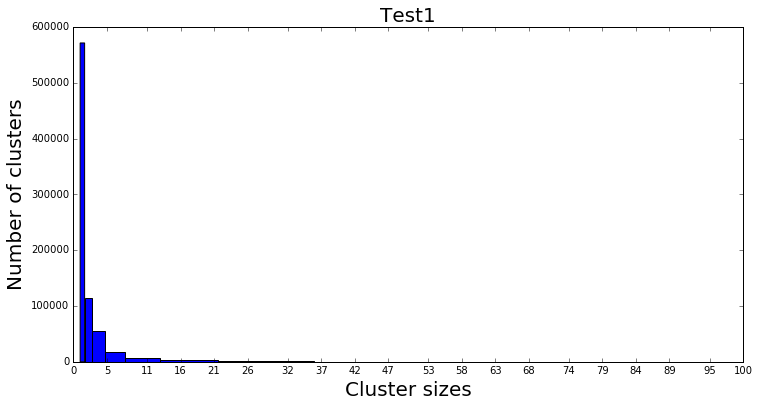

In [113]:
precluster_sizes_hist('preclusters1.txt', start = 0, log = True)

Рассмотрим более подробно хвост распределения


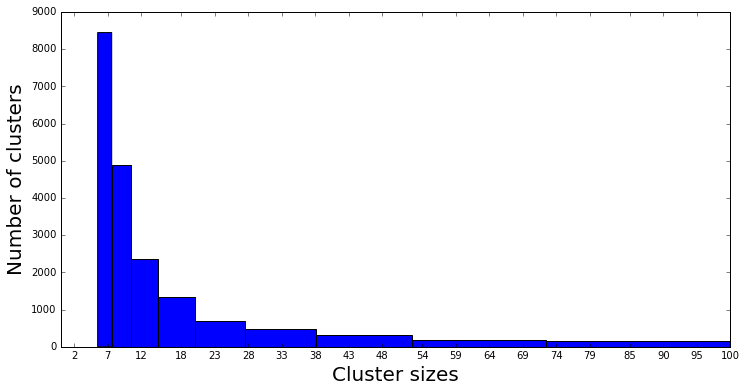

In [138]:
precluster_sizes_hist('preclusters1.txt', start = 2.1, log = True)

Максимальные размеры кластеров:

In [296]:
section_sizes = get_cluster_sizes('preclusters1.txt')
sorted_section_sizes = sorted(section_sizes.items(), key=operator.itemgetter(1))
print sorted_section_sizes[-5:-1]    


768444
[('14464', '99'), ('508118', '99'), ('221304', '99'), ('478511', '99')]


## Выборка №2
Гистограмма размеров кластеров в логарифмическом маштабе:
    - всего предкластеров: 661467
    - предкластеров с одной записью: 342072 (~50%)
    - предкластеров с менее чем 5 записями: 532128 (~85%)

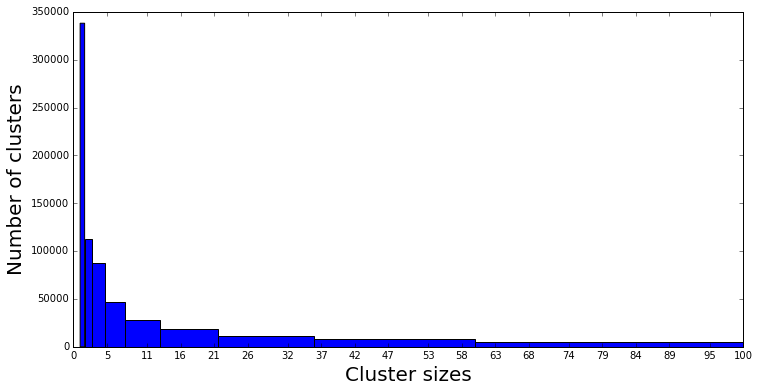

In [139]:
precluster_sizes_hist('preclusters2.txt', start = 0, log = True)

Рассмотрим более подробно хвост распределения

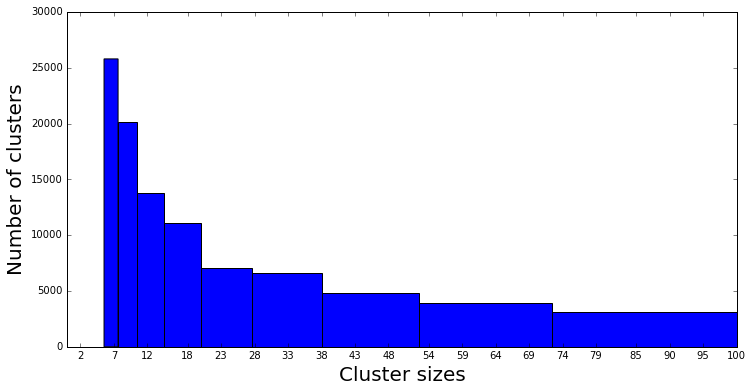

In [140]:
precluster_sizes_hist('preclusters2.txt', start = 2.1, log = True)

Максимальные размеры кластеров:

In [297]:
section_sizes = get_cluster_sizes('preclusters2.txt')
sorted_section_sizes = sorted(section_sizes.items(), key=operator.itemgetter(1))
print sorted_section_sizes[-5:-1]   

661467
[('47992', '993'), ('54530', '993'), ('65116', '995'), ('43317', '998')]


## Выборка №3
Гистограмма размеров кластеров в логарифмическом маштабе:
    - всего предкластеров: 662464
    - предкластеров с одной записью: 343176 (~50%)
    - предкластеров с менее чем 5 записями: 529525 (~80%)

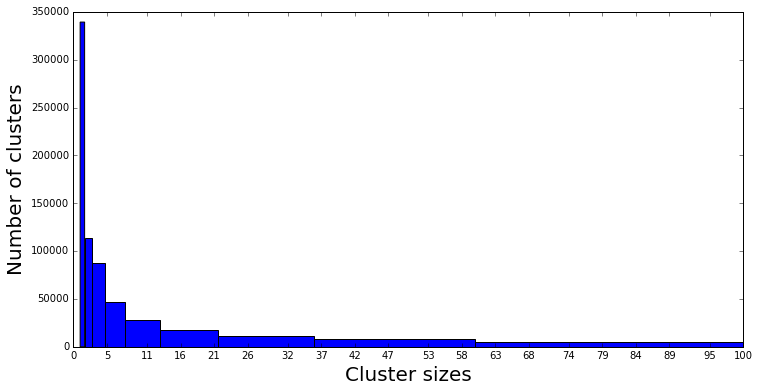

In [154]:
precluster_sizes_hist('preclusters3.txt', start = 0, log = True)

Рассмотрим более подробно хвост распределения

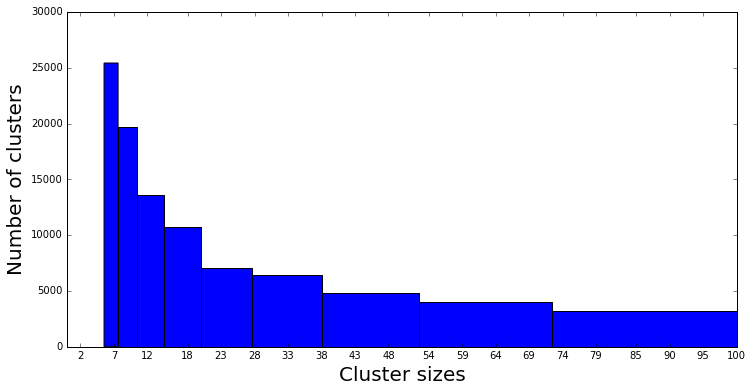

In [155]:
precluster_sizes_hist('preclusters3.txt', start = 2.1, log = True)

Максимальные размеры кластеров:

In [298]:
section_sizes = get_cluster_sizes('preclusters3.txt')
sorted_section_sizes = sorted(section_sizes.items(), key=operator.itemgetter(1))
print sorted_section_sizes[-5:-1]   

[('185264', '99'), ('77761', '99'), ('424887', '99'), ('726938', '99')]
662464


## Выборка №4
Гистограмма размеров кластеров в логарифмическом маштабе:
    - всего кластеров: 651953
    - предкластеров с одной записью: 336365 (~50%)
    - предкластеров с менее чем 5 записями: 553342 (~85%)

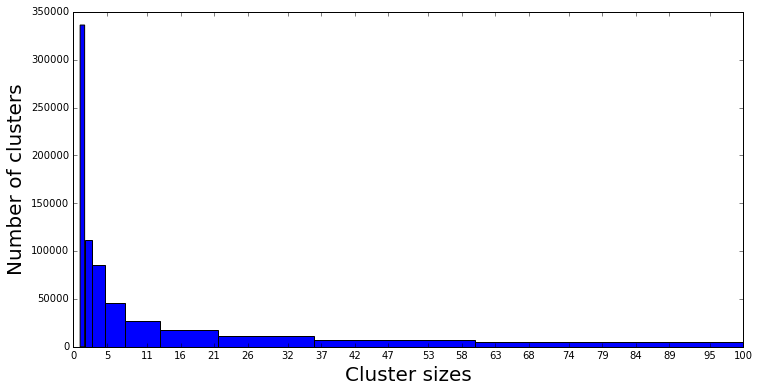

In [158]:
precluster_sizes_hist('preclusters4.txt', start = 0, log = True)

Максимальные размеры кластеров:

In [300]:
section_sizes = get_cluster_sizes('preclusters4.txt')
sorted_section_sizes = sorted(section_sizes.items(), key=operator.itemgetter(1))
print sorted_section_sizes[-5:-1]

[('365619', '99'), ('237177', '99'), ('115062', '99'), ('207340', '99')]


## Выборка №5
Гистограмма размеров кластеров в логарифмическом маштабе:
    - всего предкластеров: 656981
    - предкластеров с одной записью: 337661 (~50%)
    - предкластеров с менее чем 5 записями: 556505 (~85%)

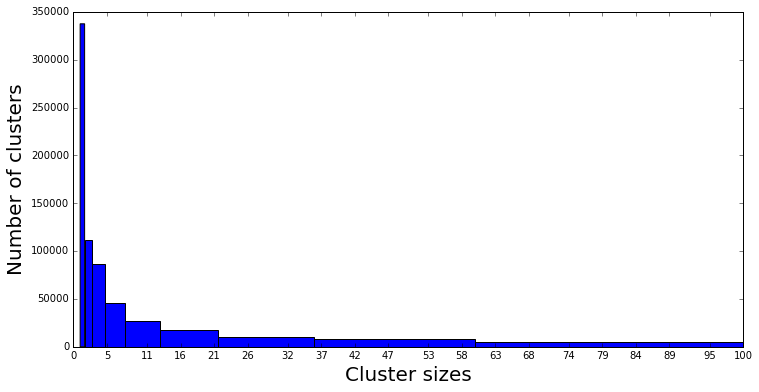

In [215]:
precluster_sizes_hist('preclusters6.txt', start = 0, log = True)

In [301]:
section_sizes = get_cluster_sizes('preclusters6.txt')
sorted_section_sizes = sorted(section_sizes.items(), key=operator.itemgetter(1))
print sorted_section_sizes[-5:-1]

[('588184', '99'), ('103106', '990'), ('101199', '990'), ('99112', '990')]


## Выборка №6
Гистограмма размеров кластеров в логарифмическом маштабе:
    - всего предкластеров: 656981
    - предкластеров с одной записью: 341564 (~35%)
    - предкластеров с менее чем 5 записями: 526520 (~55%)

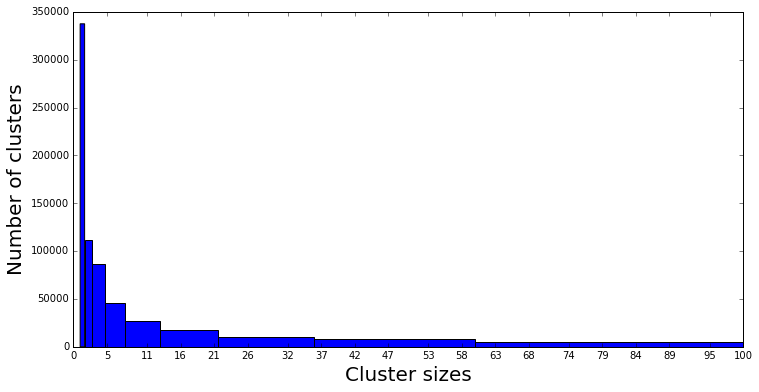

In [283]:
precluster_sizes_hist('preclusters8.txt', start = 0, log = True)

Максимальные размеры кластеров:

In [295]:
section_sizes = get_cluster_sizes('preclusters8.txt')
sorted_section_sizes = sorted(section_sizes.items(), key=operator.itemgetter(1))
print sorted_section_sizes[-5:-1]

[('588184', '99'), ('103106', '990'), ('101199', '990'), ('99112', '990')]
656981


In [290]:
print count(section_sizes.values(),['1','2','3','4','5'])

556505


### Можем сделать следующие выводы:
    - в среднем половина предкластеров размера 1 и не требует дальнейшего рассмотрения
    - в среднем большинство (85%) предкластеров небольшого размера и будут обработаны быстро
    - кластеров существенного размера менее 5%

In [232]:
# Self-explanitory
def find_bigrams(string):
    bigram_list = []
    for i in range(len(string)-1):
        bigram_list.append(string[i]+string[i+1])
    return bigram_list

from sklearn.metrics import jaccard_similarity_score

# Jaccard distance between bigramms of string1 and string 2
def jaccard_distance(string1, string2):
    bi_list1 = find_bigrams(string1)
    bi_list2 = find_bigrams(string2)
    intersection_cardinality = len(set.intersection(*[set(bi_list1), set(bi_list2)]))
    union_cardinality = len(set.union(*[set(bi_list1), set(bi_list2)]))
    return intersection_cardinality/float(union_cardinality)

### Рассмотрим несколько предкластеров подробнее 

In [254]:
section_sizes = get_cluster_sizes('preclusters6.txt')
ds = get_section('53','preclusters6.txt',section_sizes)
ds

,author,name
0,Par Jean Michon ...,Contribution experimentale a l'etude de la bio...
1,Левандо П.П.,Хоровая фактура : Монография / П.П. Левандо
2,None,О поведении древних христиан во дни воскресные...
3,Основина Лариса Григорьевна#Шуляков Леонид Вас...,"Автомобильные дороги : строительство, ремонт, ..."
4,None,двенадцатого очередного созыва. (Ноябрь 1876 г.)
5,Котеленец Валерий Степанович,Небесный поединок
6,None,Семиотика и Авангард : антология / ред.-сост. ...
7,None,Неизвестная черная книга : [Свидетельства очев...
8,None,Методическое пособие пропагандисту начального ...
9,Кручинина Евгения Юрьевна,Эколого-гигиеническая оценка материалов для до...


### Посчитаем меру Жаккара между элементами подкластера

In [279]:
def jacc_correlation(stringlist):
    l = len(stringlist)
    columns1 = []
    for i in range(l):
        columns1.append(str(i))


    dataset = pd.DataFrame(columns = columns1)
    for i in range(l):
        tmplist = []
        for j in range(l):
            tmplist.append(jaccard_distance(stringlist[i], stringlist[j]))
        tmp = pd.DataFrame([tmplist],columns = columns1)
        dataset = dataset.append(tmp,ignore_index = True)
    return dataset
    



In [273]:
jacc_correlation(ds['name'])

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,1.000000,0.050000,0.166667,0.051282,0.018868,0.134021,0.090909,0.068493,0.102804,0.041096,0.072727,0.127660
2,0.0,0.050000,1.000000,0.100917,0.071429,0.107143,0.123810,0.100000,0.214815,0.177570,0.150685,0.188679,0.128713
3,0.0,0.166667,0.100917,1.000000,0.072727,0.046512,0.237288,0.165714,0.192547,0.193798,0.166667,0.166667,0.126984
4,0.0,0.051282,0.071429,0.072727,1.000000,0.034483,0.084112,0.108280,0.094595,0.097345,0.064935,0.050847,0.178947
5,0.0,0.018868,0.107143,0.046512,0.034483,1.000000,0.047619,0.028169,0.080645,0.054945,0.080000,0.054945,0.037037
6,0.0,0.134021,0.123810,0.237288,0.084112,0.047619,1.000000,0.160920,0.172840,0.169231,0.100000,0.142857,0.166667
7,0.0,0.090909,0.100000,0.165714,0.108280,0.028169,0.160920,1.000000,0.192308,0.173184,0.105263,0.147541,0.151163
8,0.0,0.068493,0.214815,0.192547,0.094595,0.080645,0.172840,0.192308,1.000000,0.320000,0.209302,0.237500,0.207792
9,0.0,0.102804,0.177570,0.193798,0.097345,0.054945,0.169231,0.173184,0.320000,1.000000,0.180000,0.221374,0.223140


### Еще пример подкластера

In [274]:
section_sizes = get_cluster_sizes('preclusters6.txt')
ds = get_section('301591','preclusters6.txt',section_sizes)
ds

,author,name
0,None,"№302, Arg.12"
1,None,"AIP informacao A.7 1981, № 4"
2,Кукса Алексей Владимирович,Чугунные сталеразливочные изложницы / А.В. Кукса
3,Curtius Rufus Quintus,Histoire d'Alexandre le Grand
4,None,Уголовно-процессуальный кодекс Российской Феде...
5,None,АНАЛИТИЧЕСКИЕ ВОЗМОЖНОСТИ МЕТОДА ВНУТРЕННЕГО Т...
6,Минькова Раиса Дмитриевна,Тетрадь для лабораторных работ по физике. 7 класс
7,Горский с.-х. ин-т,Трудовые ресурсы колхозов горного Дагестана и ...
8,Кравчук Александр Степанович,Механика контактного взаимодействия тел с круг...
9,None,"Система стандартов по информации, библиотечном..."


### Посчитаем меру Жаккара между элементами подкластера

In [280]:
jacc_correlation(ds['name'])

,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.054054,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.015152
1,0.054054,1.000000,0.000000,0.0,0.006289,0.000000,0.014493,0.000000,0.000000,0.012048
2,0.000000,0.000000,1.000000,0.0,0.100629,0.026549,0.049383,0.070000,0.076923,0.076087
3,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.006289,0.100629,0.0,1.000000,0.051282,0.101266,0.146199,0.140244,0.125749
5,0.000000,0.000000,0.026549,0.0,0.051282,1.000000,0.017699,0.014815,0.007874,0.000000
6,0.000000,0.014493,0.049383,0.0,0.101266,0.017699,1.000000,0.092784,0.054348,0.101124
7,0.000000,0.000000,0.070000,0.0,0.146199,0.014815,0.092784,1.000000,0.178218,0.165049
8,0.000000,0.000000,0.076923,0.0,0.140244,0.007874,0.054348,0.178218,1.000000,0.132653
9,0.015152,0.012048,0.076087,0.0,0.125749,0.000000,0.101124,0.165049,0.132653,1.000000


### Можем сделать вывод: в некоторых случаях предкластеризация проводится не очень удачно

### Рассмотрим кластеризацию на одном из больших кластеров

In [309]:
section_sizes = get_cluster_sizes('preclusters6.txt')
ds = get_section('180','preclusters6.txt',section_sizes)
ds

,author,name
0,Алексеев Сергей Петрович,Собрание сочинений
1,"Богров, Григорий Исаакович",Собрание сочинений :
2,None,Собрание сочинений
3,None,Собрание сочинений
4,None,Собрание сочинений
5,None,Собрание сочинений
6,None,Собрание сочинений
7,None,Собрание сочинений
8,None,Собрание сочинений
9,None,Собрание сочинений


In [310]:
tmp = [180,
623142,
311276,
316522,
317361,
624650,
317409,
625277,
626902,
319934,
627003,
325301,
627417,
325508,
627768,
326062,
326086,
630958,
327227,
631507,
327890,
636345,
330608,
637388,
330984,
642215,
331792,
646776,
331843,
648043,
332040,
648464,
332601,
648505,
333119,
648938,
334410,
650843,
339999,
650860,
]


После кластеризации все в одном кластере

In [311]:
get_data_from_idset(tmp)

,author,name
0,Алексеев Сергей Петрович,Собрание сочинений
1,None,Собрание сочинений
2,None,Собрание сочинений
3,None,Собрание сочинений
4,None,Собрание сочинений
5,Верн Жюль,Собрание сочинений
6,None,Собрание сочинений
7,None,Собрание сочинений
8,None,Собрание сочинений
9,Вл. Ленский,Собрание сочинений


### Рассмотрим на примере кластеров меньшего размера

In [11]:
section_sizes = get_cluster_sizes('preclusters6.txt')
ds = get_section('8','preclusters6.txt',section_sizes)
print ("Предкластер:")
ds

Предкластер:


,author,name
0,Гордеев Владимир Ильич,Практикум по инфузионной терапии при неотложны...
1,Богдарин Андрей Юрьевич,Буквы в азбуке
2,None,О замене пеленок бумагой в физическом воспитан...
3,None,"Христианский Восток : Серия, посвященная изуче..."
4,None,Советский Союз на международных конференциях п...
5,None,"Слово, сказанное в церкви Киево-Братского мона..."
6,Зимин В.Н.,Новые подходы и методы в организации образоват...
7,None,"""Картофельный бунт"" в России и новый материал ..."


После кластеризации все в разных кластерах

In [282]:
f = open('preclusters8.txt','r')
t = open('tmp.txt','w')
i = 0
for line in f:
    if line[0:2] == 'SE':
        t.write('SecSize '+str(i)+'\n')
        i = 0
    else:
        i+=1
    t.write(line)
    
f.close()
t.close()

## Спасибо за внимание.